# Fitting the Low-Rank plus Sparse estimator in R

*Note*: These functions and more will soon be available as part of an R package on CRAN.
In the meantime, this tutorial shows, in order, how to: 
* 1) [fit the estimator for a given value of the tuning parameters](#first)
* 2) [fit a whole path](#second)
* 3) [perform cross-validation](#third)
* 4) [use a robust estimator of the correlation matrix based on Kendall correlations.](#fourth)
* 5) [combine this estimator with GES and IDA in order to compute causal effects in the presence of hidden variables.](#fifth)

Questions or remarks? : benjamin dot frot @ gmail dot com

## Required packages

The following packages (all available on CRAN) are required to run the code (fit the estimator etc...)

In [1]:
packages <- c("Matrix", "MASS", "mvtnorm", "RSpectra", "matrixcalc", "pcaPP", "cvTools")
install.packages(packages)
library("Matrix")
library("MASS")
library("mvtnorm")
library("RSpectra")
library("matrixcalc")
library("pcaPP")
library("cvTools")


The downloaded binary packages are in
	/var/folders/d7/dhbt8tyd3ksf__y96t051n100000gn/T//RtmpP8gW39/downloaded_packages


Warning message:
“package ‘Matrix’ was built under R version 3.4.4”Warning message:
“package ‘MASS’ was built under R version 3.4.4”Warning message:
“package ‘mvtnorm’ was built under R version 3.4.4”Warning message:
“package ‘RSpectra’ was built under R version 3.4.4”Loading required package: lattice
Loading required package: robustbase
Warning message:
“package ‘robustbase’ was built under R version 3.4.4”

The following additional packages are used in this notebook:

In [2]:
packages <- c("ggplot2")
install.packages(packages)
library(ggplot2)
library(reshape2)

library(repr)
options(repr.plot.width=4, repr.plot.height=4)


The downloaded binary packages are in
	/var/folders/d7/dhbt8tyd3ksf__y96t051n100000gn/T//RtmpP8gW39/downloaded_packages


Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘repr’ was built under R version 3.4.4”

## Fitting the estimator for a given value of the tuning parameters  <a class="anchor" id="first"></a>

Recall that given an $n \times p$ data matrix $X$ constiting of $n$ realisations of a random vector $x \in \mathbb{R}^p \sim \mathcal{N}(0, \Sigma)$, the so-called "Low-rank plus Sparse" (LRpS) estimator defined in https://projecteuclid.org/euclid.aos/1351602527 optimises the following function:
$$
  (\hat{S} , \hat{L}) = \arg \min_{S - L \succ 0, L \succeq 0} - \log\det (S - L) + 
  Tr((S - L)\hat{\Sigma}) + \lambda (\gamma ||S||_1 + (1 - \gamma)Tr(L) ),
$$
where $\hat{\Sigma}$ is some estimator of $\Sigma$ (typically the sample covariance matrix), $\lambda > 0$ and $\gamma \in (0, 1)$ are tuning parameters.

We implement the algorithm with restarts described here: ftp://ftp.math.ucla.edu/pub/camreport/cam12-35.pdf

### Generate some data

Let us start by generating some synthetic data we can fit the estimator to.

In [3]:
p <- 100 # Number of obvserved variables 
h <- 3 # Number of hidden variables
n <- 2000 # Number of samples
set.seed(0)
source("./utils//simulate_data.R")
toy.data <- simulate.latent.ggm.data(n = n, p = p, h = h, outlier.fraction = 0.0) # Data from a multivariate normal
X <- toy.data$obs.data # The observed data
X <- scale(X)
# The true sparse matrix we try to estimate
true.S <- toy.data$true.precision.matrix[1:p,1:p]
# Let us keep only the non-diagonal entries
true.S <- 1 * ((true.S - diag(diag(true.S))) != 0)

Let us see what the sparse matrix we try to estimate looks like

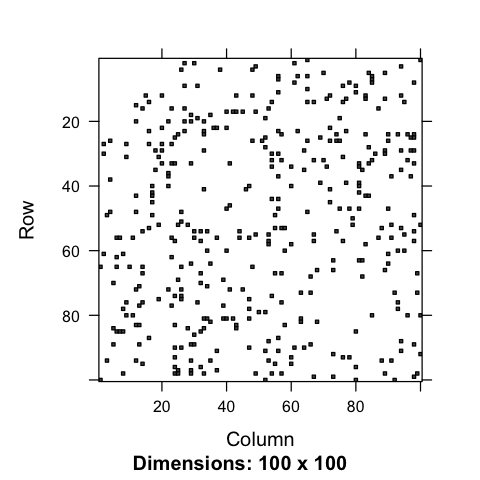

In [4]:
image(Matrix(true.S, sparse = T))

### Fit the estimator

[1] "Term Msg: Convergence reached."
[1] "Number of iterations: 30"
[1] "Precision: 0.9 Recall: 0.139896373056995"
[1] "Rank of L: 3"


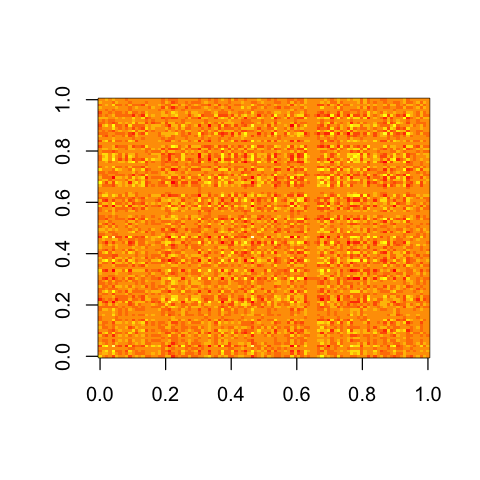

In [5]:
source("./lrps/fast_lrps_admm.R")
Sigma <- cor(X) # The sample correlation matrix

# Some reasonable values of the tuning parameters
lambda <- 0.55
gamma <- 0.15 # A small value of gamma favours an L with a small rank.
lam1 <- lambda * gamma
lam2 <- lambda * (1 - gamma)

fit <- fit.low.rank.plus.sparse(Sigma = Sigma, Lambda1 = lam1, Lambda2 = lam2, n = nrow(X), 
                                tol = 1e-07, print_progress = TRUE)
print(paste("Term Msg:", fit$termmsg))
print(paste("Number of iterations:", fit$iter))

# Let us get the parameters we fitted
S <- fit$S # The estimated Shat
Sbin <- 1 * ((fit$S - diag(diag(fit$S))) !=0)
L <- fit$L

# Let us see what the precision and recall are for the recovery of S
recall <- sum(Sbin * true.S) / sum(true.S)
precision <- sum(Sbin * true.S) / sum(Sbin)
print(paste("Precision:", precision, "Recall:", recall))
print(paste("Rank of L:", sum(eigen(L)$val > 1e-6)))

# Let us look at the low-rank matrix L
image(L)

## Fit a whole path  <a class="anchor" id="second"></a>

Since we use the "warm-starts" (*i.e.* resuse the value of the previous fit), we can also fit a whole regularisation path for a given value of $\gamma$. 

One can provide their own sequence of lambdas, or let the program choose `n.lambdas` within a reasonable range. 
The default is a geometric sequence of `n.lambdas` values, ranging from `lambda.max` to `lambda.ratio * lambda.max`.
Since it does not make much sense to have a very dense $S$, the function stops computing the path when $S$ reaches a sparsity of `max.sparsity` (default 0.5). Likewise, if the rank of $L$ is greater than `max.rank`, we stop (default min(n-1, p-1)).

[1] "Length of the path 17"


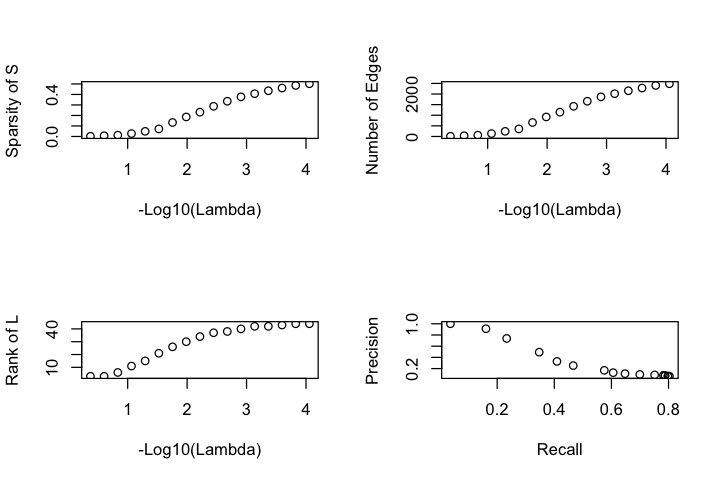

In [6]:
source("./lrps/fit_path.R")
lrps.path <- fit.low.rank.plus.sparse.path(Sigma = Sigma, gamma = 0.15, n = nrow(X), n.lambdas = 40,
                                           lambda.ratio = 1e-04, tol=1e-07)
# The output is a list, one per value of lambda
print(paste("Length of the path", length(lrps.path)))
# There is a function to show the basic properties of the path.
options(repr.plot.width=6, repr.plot.height=4)
show.low.rank.plus.sparse.path(lrps.path, ground.truth = true.S)

[1] "Rank of L 3"


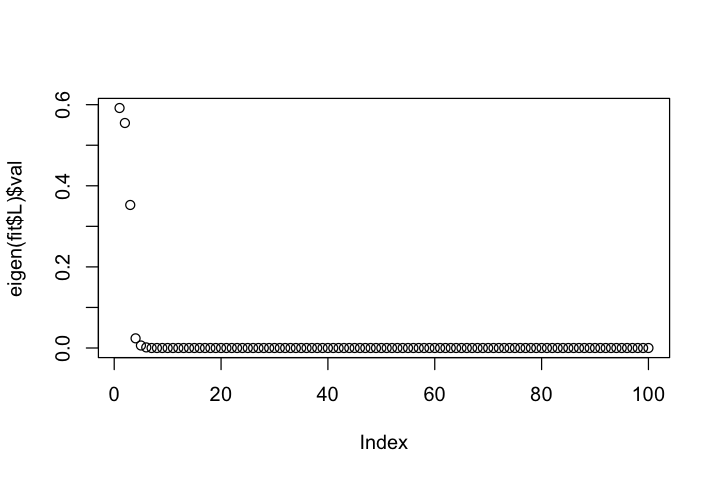

In [7]:
# Here is how to access the fit associated with the 2rd value of lambda (for example)
fit <- lrps.path[[3]]$fit
print(paste("Rank of L", lrps.path[[2]]$rank.L))
# The spectrum of L
plot(eigen(fit$L)$val)

## Performing cross-validation  <a class="anchor" id="third"></a>

In order to pick $\lambda$ (and possiby $\gamma$) one can perform cross-validation.

Here, we perform 5-fold cross-validation for a given value of $\gamma$. The function first computes a path in order to estimate which values of $\lambda$ are reasonable. It then performs cross-validaion.

In [8]:
source("./lrps/cross_validation.R")
xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = 0.15, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = TRUE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-03)

[1] "### Computing the path on the full dataset first ###"
[1] "Fitting with gamma= 0.15  and lambda= 0.688344311963032 Sparsity: 0.000202020202020202 Rank of L: 2"
[1] "Fitting with gamma= 0.15  and lambda= 0.5791695598648 Sparsity: 0.00323232323232323 Rank of L: 3"
[1] "Fitting with gamma= 0.15  and lambda= 0.487310453859029 Sparsity: 0.00848484848484849 Rank of L: 3"
[1] "Fitting with gamma= 0.15  and lambda= 0.410020648349902 Sparsity: 0.0133333333333333 Rank of L: 6"
[1] "Fitting with gamma= 0.15  and lambda= 0.34498938149582 Sparsity: 0.0246464646464646 Rank of L: 11"
[1] "Fitting with gamma= 0.15  and lambda= 0.290272389509764 Sparsity: 0.0412121212121212 Rank of L: 15"
[1] "Fitting with gamma= 0.15  and lambda= 0.244233778287257 Sparsity: 0.0565656565656566 Rank of L: 18"
[1] "Fitting with gamma= 0.15  and lambda= 0.205497114476548 Sparsity: 0.0911111111111111 Rank of L: 21"
[1] "Fitting with gamma= 0.15  and lambda= 0.172904273742674 Sparsity: 0.114545454545455 Rank of L: 26"


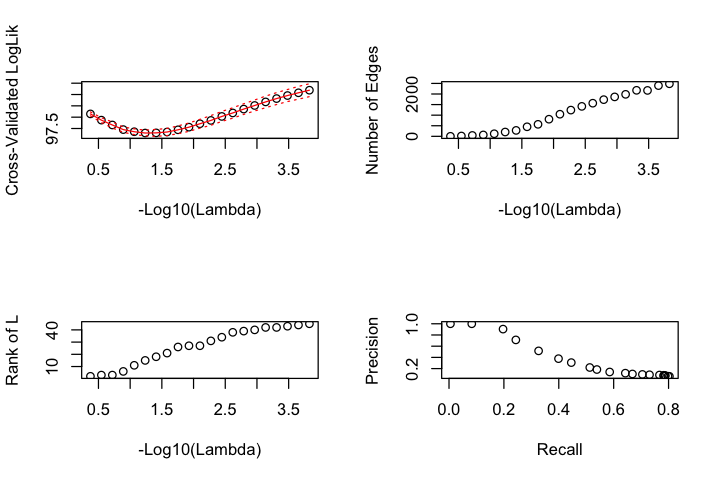

In [9]:
# There is also a function to show the cross-validated path.
show.cross.validate.low.rank.plus.sparse(xval.path, ground.truth = true.S) # The ground truth is optional

In [10]:
# We can pick the best graph according to cross-validation according to two criteria
best.fit <- choose.cross.validate.low.rank.plus.sparse(xval.path = xval.path)
print(paste("Sparsity:", best.fit$sparsity))
# This one typically picks a more parsimonious models
best.fit.hastie <- choose.cross.validate.low.rank.plus.sparse(xval.path = xval.path, method = "hastie")
print(paste("Sparsity:", best.fit.hastie$sparsity))

[1] "Sparsity: 0.0412121212121212"
[1] "Sparsity: 0.0246464646464646"


We can compare the outcome of the cross-validation selection procedure for those two criteria:

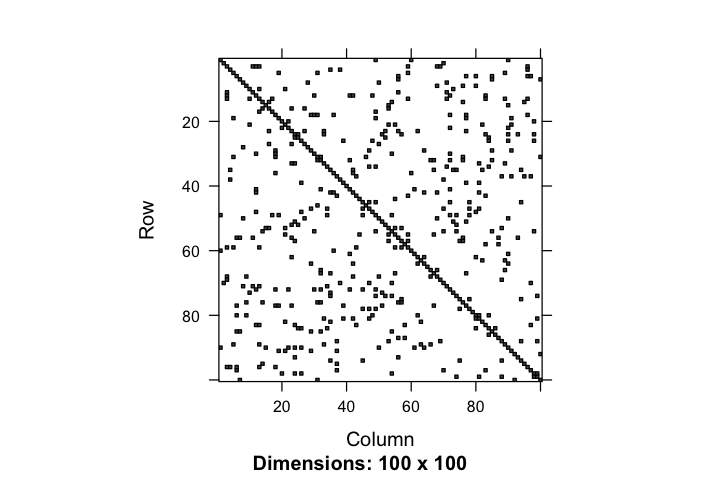

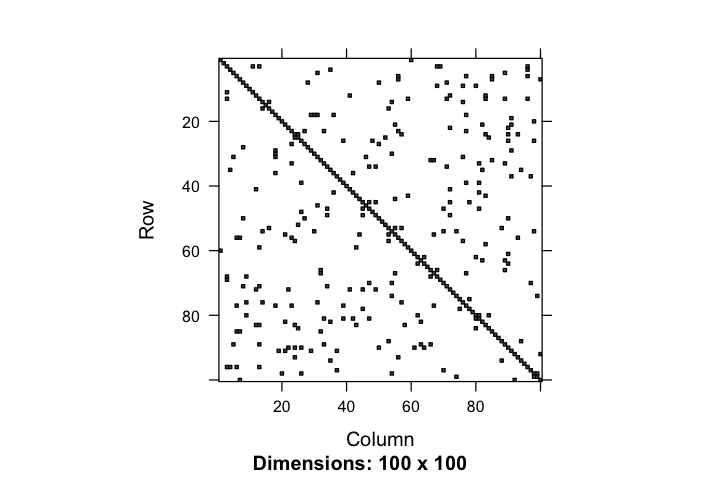

In [11]:
par(mfrow=c(1,2))
image(Matrix(best.fit$fit$S!=0, sparse=T))
image(Matrix(best.fit.hastie$fit$S!=0, sparse=T))
par(mfrow = c(1,1))

Now, let us perform cross-validation for a number of values of $\gamma$ and pick the best. Ideally we shoould account for the standard deviation in the cross-validated loglikelihoods.

*Note that if you want to be able to compare the cross-validated values for different values of $\gamma$, you must set the seed parameter. Otherwise, we cannot compare the output of two runs of the function.*

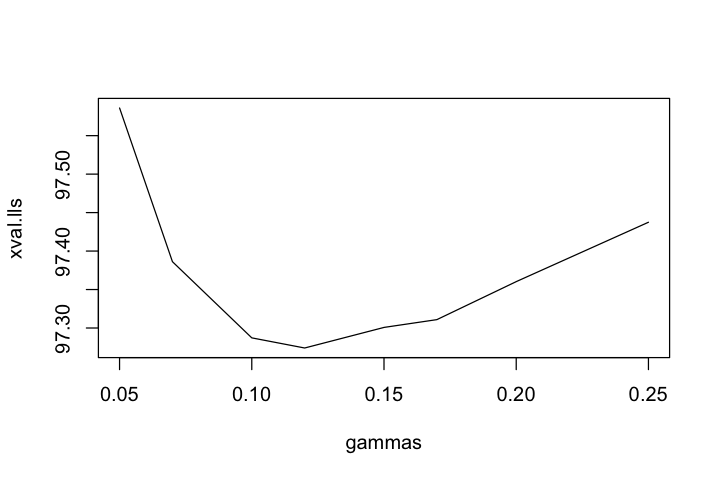

In [12]:
xval.lls <- c()
gammas <- c(0.05, 0.07, 0.1, 0.12, 0.15, 0.17, 0.2, 0.25)
for(gamma in gammas) {
    xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = gamma, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = FALSE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-03)
    bf <- choose.cross.validate.low.rank.plus.sparse(xval.path)$mean_xval_ll
    xval.lls <- c(xval.lls, bf)
}
plot(gammas, xval.lls, type='l')

It looks like cross-validation selects a value of 0.12. Recall that cross-validation tends to *overselect*. The ideal parameters for $\lambda$ and $\gamma$ probably lead to a more parsimonious model.

In [13]:
xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = 0.12, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = FALSE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-03)
bf <- choose.cross.validate.low.rank.plus.sparse(xval.path)
print(paste(bf$lambda, bf$number.of.edges, bf$sparsity, bf$rank.L))

[1] "0.305292222859071 436 0.0880808080808081 11"


## Dealing with outliers: Using a robust estimator of the covariance.  <a class="anchor" id="fourth"></a>

Finally, we generate some data with outliers and use an estimator of the covariance matrix which is based on a modified version of the Kendall correlation matrix

In [14]:
# Let us generate data with outliers
p <- 100 # Number of obvserved variables 
h <- 3 # Number of hidden variables
n <- 2000 # Number of samples
set.seed(0)
source("./utils//simulate_data.R")
toy.data <- simulate.latent.ggm.data(n = n, p = p, h = h, outlier.fraction = 0.1) # 10% are outliers (Cauchy)
X <- toy.data$obs.data # The observed data
X <- scale(X)
# The true sparse matrix we try to estimate
true.S <- toy.data$true.precision.matrix[1:p,1:p]
# Let us keep only the non-diagonal entries
true.S <- 1 * ((true.S - diag(diag(true.S))) != 0)

In [15]:
# Fit the path with the sample correlation matrix
xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = 0.12, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = FALSE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-03)

Warning message in .split.bregman.low.rank.plus.sparse.update.parameters(parameters, :
“The accelerated ADMM algorithm restarted 100 times in a row. It seems like the required convergence tolerance cannot be achieved. This might due to the problem being too ill-posed. For example, the value of gamma might be too large given the ratio p/n. You might also want to consider trying a smaller value of mu.
”Warning message in .split.bregman.low.rank.plus.sparse.update.parameters(parameters, :
“The accelerated ADMM algorithm restarted 100 times in a row. It seems like the required convergence tolerance cannot be achieved. This might due to the problem being too ill-posed. For example, the value of gamma might be too large given the ratio p/n. You might also want to consider trying a smaller value of mu.
”Warning message in .split.bregman.low.rank.plus.sparse.update.parameters(parameters, :
“The accelerated ADMM algorithm restarted 100 times in a row. It seems like the required convergence tole

In [16]:
# Fit the path with the Kendall correlation estimator
source("./utils//covariance_estimators.R")
Kendall.xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = 0.12, n = nrow(X), 
                                                         covariance.estimator = Kendall.correlation.estimator, 
                                                         n.folds = 5, 
                                                         verbose = FALSE, seed = 1,
                                                         n.lambdas = 40, lambda.ratio = 1e-03)

This is the x-validated path when using the sample correlation matrix:

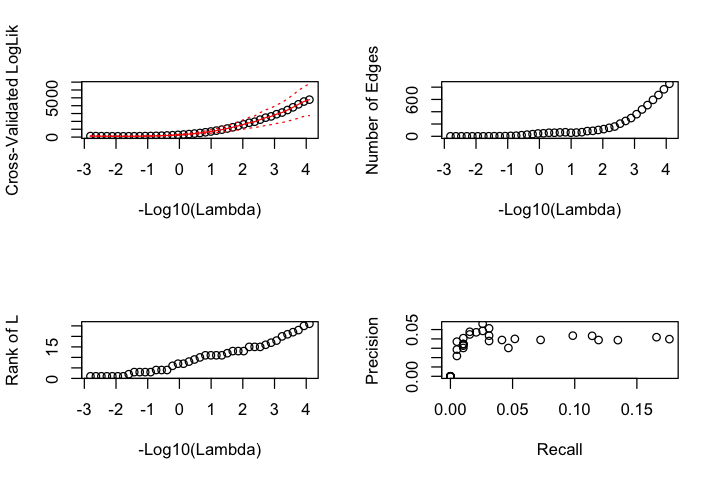

In [17]:
# Look at the path estimated with the sample covariance matrix
show.cross.validate.low.rank.plus.sparse(xval.path, ground.truth = true.S)

And now the path estimated when using the Kendall estimator:

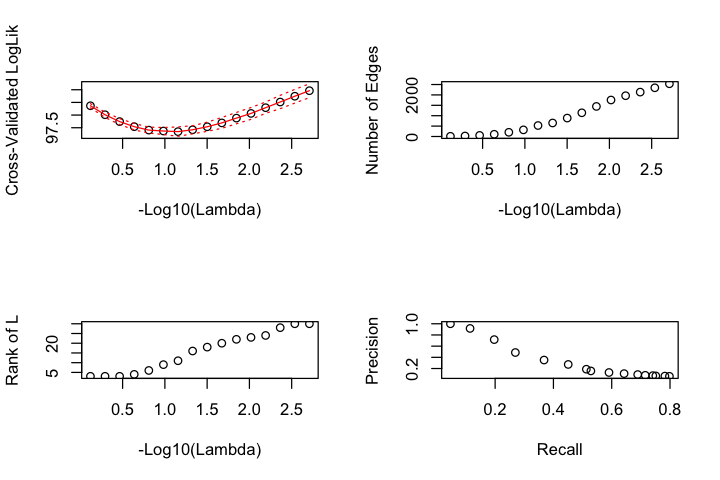

In [18]:
# Look at the path estimated with the Kendall estimator
show.cross.validate.low.rank.plus.sparse(Kendall.xval.path, ground.truth = true.S)

# Application: Using the code to compute causal effects in the presence of latent variables.  <a class="anchor" id="fifth"></a>

Here, we use the code showcased above as part of the LRpS+GES estimator introduced here: https://arxiv.org/abs/1708.01151 .

We will:
*  Generate data according to a Directed Acyclic graph with latent variables. 
*  Perform cross-validation with LRpS so as to select $\gamma$ and $\lambda$, as above.
*  Use the resulting $\hat{S}$ as input to the GES algorithm.
*  Run IDA in order to estimate multisets of causal effects.

## Prerequisites

In order to run GES and IDA, you also need to install the PCALG package. This package is on CRAN but also has dependencies on bioconductor, so you might need to install other packages (*e.g.* RBGL) yourself from bioconductor. This is really straightforward and you can follow instructions, *e.g.* here: https://www.bioconductor.org/packages/release/bioc/html/RBGL.html

In [19]:
install.packages(c("pcalg", "bnlearn", "igraph"))
library(pcalg)
library(bnlearn)


The downloaded binary packages are in
	/var/folders/d7/dhbt8tyd3ksf__y96t051n100000gn/T//RtmpP8gW39/downloaded_packages


Warning message:
“package ‘pcalg’ was built under R version 3.4.4”Warning message:
“package ‘bnlearn’ was built under R version 3.4.4”
Attaching package: ‘bnlearn’

The following objects are masked from ‘package:pcalg’:

    dsep, pdag2dag, shd, skeleton

The following object is masked from ‘package:stats’:

    sigma



## Generate some data according to a DAG with latent variables

In [20]:
source("./utils/simulate_data_from_latent_dag.R")
p <- 50 # Number of obvserved variables 
h <- 3 # Number of hidden variables
n <- 500 # Number of samples
set.seed(0)
toy.data <- simulate.latent.DAG.data(nl = h, nv = p, ss = n, sp = 0.05)
X <- toy.data$data # The observed data
X <- scale(X)

## Compute LRpS and select a graphical model using cross-validation

We start by estimating $\hat{S}, \hat{L}$ using 5-fold cross-validation.

In [21]:
xval.lls <- c()
gammas <- c(0.05, 0.07, 0.1, 0.12, 0.15, 0.17, 0.2)
for(gamma in gammas) {
    xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = gamma, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = FALSE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-04)
    bf <- choose.cross.validate.low.rank.plus.sparse(xval.path)$mean_xval_ll
    xval.lls <- c(xval.lls, bf)
}
best.gamma <- gammas[which.min(xval.lls)]

In [22]:
print(paste("Selected value of Gamma", best.gamma))

[1] "Selected value of Gamma 0.17"


In [23]:
xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = best.gamma, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = FALSE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-04)

[1] "Estimated Correlation Matrix without the confounding"


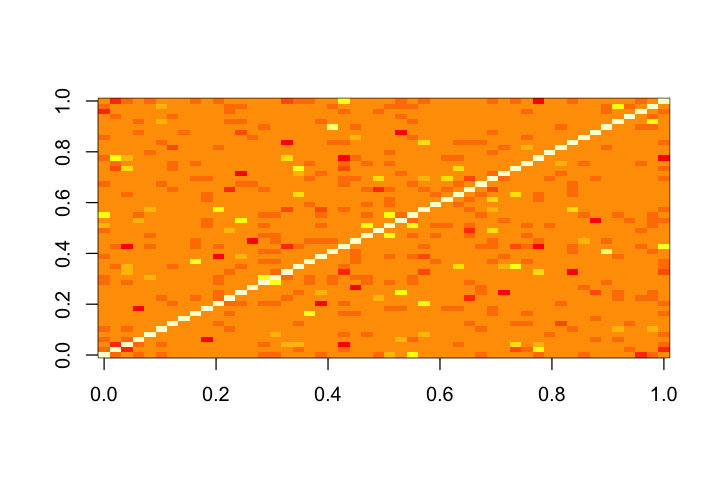

In [24]:
print("Estimated Correlation Matrix without the confounding")
image(cov2cor(solve(choose.cross.validate.low.rank.plus.sparse(xval.path)$fit$S)))

## Fit GES using ${\hat{S}}^{-1}$ as input

In [32]:
source("./utils/generate_data_for_GES.R")
selected.S <- choose.cross.validate.low.rank.plus.sparse(xval.path)$fit$S
# Because the GES function of pcalg can only take a data matrix as input and not a covariance matrix, 
# we simulate data with the exact same sample covariance matrix as the estimated one. 
# This is a trick that lets use the GES function of pcalg.
fake.data <- generate.data.for.GES(Sest = selected.S, n=n, p=p)

source("./utils/run_GES.R")
source("./utils/compute_metrics.R")
source("./utils/process_curve.R")

# We now compute the GES path on the resulting data and compute the BIC at each step. 
lrps.ges.output <- run.GES.and.select.with.BIC(obs.data = fake.data, nv = p, sim.data = toy.data)
metrics <- sapply(lrps.ges.output$path, function(a) {get("metric", a)})
idx1 <- which(rownames(metrics) == "prec.sk")
idx2 <- which(rownames(metrics) == "rec.sk")
prec <- unlist(metrics[idx1,])
rec <- unlist(metrics[idx2,])
# The code to process the curve is a bit messy: it simply makes sure that the cure is non decreasing and interpolates
# the precision at fixed values of the recall
lrps.ges.prs.sk <- process_curve(cbind(prec, rec))

In [26]:
# We now compute the GES path on the original dataset, for comparison
ges.output <- run.GES.and.select.with.BIC(obs.data = X, nv = p, sim.data = toy.data)
metrics <- sapply(ges.output$path, function(a) {get("metric", a)})
idx1 <- which(rownames(metrics) == "prec.sk")
idx2 <- which(rownames(metrics) == "rec.sk")
prec <- unlist(metrics[idx1,])
rec <- unlist(metrics[idx2,])
ges.prs.sk <- process_curve(cbind(prec, rec))

As an example, let us compare the precision/recall curves obtained by varying the strength of the regularisation of the GES algorithm. On the hand, we have LRpS+GES, on the other GES that we run on the original dataset.

Warning message:
“Removed 24 rows containing missing values (geom_path).”

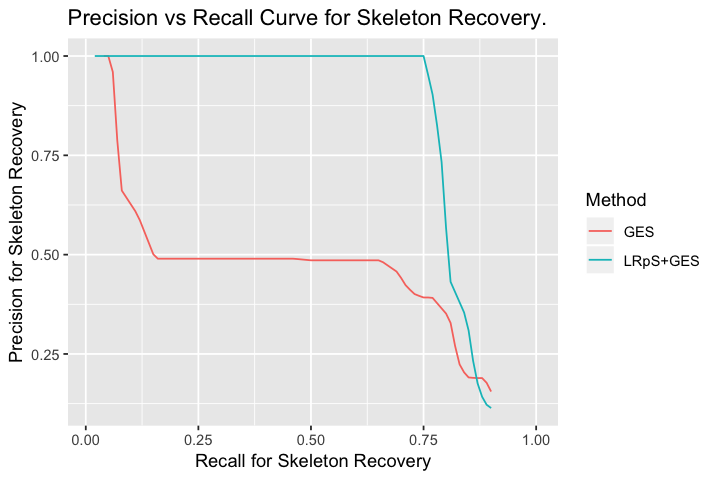

In [27]:
# Plot the results
d <- rbind(as.data.frame(lrps.ges.prs.sk), as.data.frame(ges.prs.sk))
d$Method <- c(rep("LRpS+GES", length(lrps.ges.prs.sk$x)), rep("GES", length(ges.prs.sk$x)))
pl <- ggplot(d, aes(x=x, y=y)) + geom_line(aes(colour=Method)) +
  xlab("Recall for Skeleton Recovery") + ylab("Precision for Skeleton Recovery") +
  ggtitle(paste("Precision vs Recall Curve for Skeleton Recovery."))
pl

## Compute causal effects using IDA

Finally, we select one graph along the GES path using the BIC. For this PCDAG, we use IDA and rank the causal effects. This is compared to the true causal effects.

In [28]:
source("./utils/compute_causal_effects.R")
lrps.ges.ida.results <- compute.causal.effects(selected.S, ges.fit = lrps.ges.output$best.fit,
                       p = p, n = n, dataset=toy.data)

In [29]:
# This use of solve(cor(X)) is nasty and not necessary. This is just to make it work with the 
# function compute.causal.effects.
# This step can be *very slow* because the graph appears very dense due to the latent variables.....
ges.ida.results <- compute.causal.effects(solve(cor(X)), ges.fit = ges.output$best.fit,
                       p = p, n = n, dataset=toy.data)

In [30]:
lrps.ges.ida.pr <- process_curve(lrps.ges.ida.results$IDA_prec_red[,c(2,1)])
ges.ida.pr <- process_curve(ges.ida.results$IDA_prec_red[,c(2,1)])

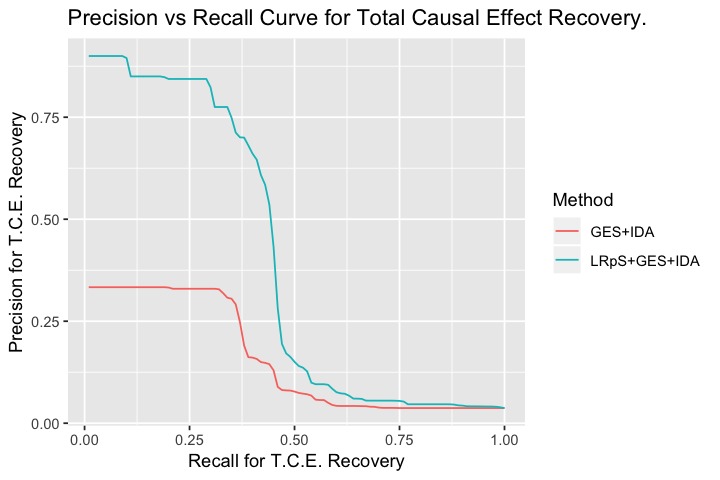

In [31]:
# Plot the results
d <- rbind(as.data.frame(lrps.ges.ida.pr), as.data.frame(ges.ida.pr))
d$Method <- c(rep("LRpS+GES+IDA", length(ges.ida.pr$x)),
              rep("GES+IDA", length(ges.ida.pr$x)))
pl <- ggplot(d, aes(x=x, y=y)) + geom_line(aes(colour=Method)) +
  xlab("Recall for T.C.E. Recovery") + ylab("Precision for T.C.E. Recovery") +
  ggtitle(paste("Precision vs Recall Curve for Total Causal Effect Recovery."))
pl